# Illustrating the consequences of transformer fine-tuning for text classification

This notebook illustrates how fine-tuning a transformer encoder model for text classifciation affects its embedding behavior.

We take a classifier trained fro pledge detection in party manifestsos created in notebook [transformer_classifier_finetuning.ipynb](./transformer_classifier_finetuning.ipynb)

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/dia_cta_course/blob/main/notebooks/block2/day1/finetuning_logic_illustrated.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

**Note:** If running on Google Colab, make sure to use a GPU runtime (go to Runtime > Change runtime type, select "T4 GPU", and click save)

In [ ]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    !pip install simpletransformers==0.70.5

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, set_seed

import umap

import matplotlib.pyplot as plt

from typing import List

from tqdm.auto import tqdm

In [7]:
# check which device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
base_path = Path("/content/advanced_text_analysis/" if COLAB else "../../../")
data_path = base_path / "data" / "labeled" / "fornaciari_we_2021"
models_path = base_path / "models"

In [11]:
SOURCE_MODEL_NAME = 'roberta-base'
FINETUNED_MODEL_NAME = models_path / "roberta-base-pledge-binary"

#### Model access {style="color: orange"}

Note that to use the **fintuned model**, you first need to run the code in notebook [transformer_classifier_finetuning.ipynb](./transformer_classifier_finetuning.ipynb) and save the model locally.

## Load the data

#### Load the data

In [12]:
fp = data_path / "fornaciari_we_2021-pledge_binary.tsv"
if not fp.exists():
    url = "https://cta-text-datasets.s3.eu-central-1.amazonaws.com/labeled/fornaciari_we_2021/fornaciari_we_2021-pledge_binary.tsv"
    df = pd.read_csv(url, encoding = "ISO-8859-1")
    fp.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(fp, index=False, encoding = "ISO-8859-1")

df = pd.read_csv(fp, sep="\t")

df = df.loc[df['metadata__split']=='dev', ['text', 'label']]
df = df[~df.text.isna()]

In [13]:
id2label = {0: "no-pledge", 1: "pledge"}
label2id = {v: k for k, v in id2label.items()}

In [14]:
# draw 100 examples per class (sampled at random)
examples = df.groupby('label').sample(100, random_state=42).sample(frac=1.0, random_state=42)
# show 2 examples per class
examples.groupby('label').sample(2, random_state=42).to_dict(orient='records')

[{'text': 'BJP will take immediate and decisive action to address these issues on a priority basis .',
  'label': 0},
 {'text': 'A time to reestablish the core values that have made India unique .',
  'label': 0},
 {'text': 'National scholarships for boys and girls belonging to scheduled castes and scheduled tribes will be further increased .',
  'label': 1},
 {'text': 'Set up an independent National Fiscal Responsibility Council that will submit an annual report to the Parliament on the progress made in achieving our fiscal commitments .',
  'label': 1}]

## Inspect the transformer embeddings

Let's first define a function for getting the final contextualized embeddings ("last hidden state") computed by the model:

In [15]:
# helper function to get the transformer embeddings of a list of texts
def get_last_hidden_state(texts: List[str], tokenizer, model, batch_size: int=32): 
    set_seed(42)
    embeddings = []    
    for i in tqdm(range(0, len(texts), batch_size)):
        # tokenize texts
        batch_inputs = tokenizer(texts[i:i+batch_size], padding='max_length', truncation=True, return_tensors="pt")          
        # get the final hidden layer embeddings
        with torch.no_grad():
            batch_outputs = model(**batch_inputs.to(model.device), output_hidden_states=True)
            # selects all rows (:) and the first column (0) of the last_hidden_state tensor, which corresponds to the representation of the [CLS] that is typically used for classification tasks.
            batch_embeddings = batch_outputs.hidden_states[-1][:, 0].cpu().numpy()
        embeddings.append(batch_embeddings)
            
    embeddings = np.concatenate(embeddings, axis=0)  
    return embeddings

### before fine-tuning

Let's analyze the sentences' contextualized embeddings before fine-tuning the model for the classification task:

In [16]:
# load the source model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL_NAME, num_labels=len(label2id), label2id=label2id).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# get the transformer embeddings
embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/7 [00:00<?, ?it/s]

Let's visualize how these examples of the different topics cluster in the original model's output embedding space.
To allow visual inspection, we'll reduce the embedding dimension to 2 dimensions using UMAP:

In [18]:
# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
embeddings_2d = reducer.fit_transform(embeddings)

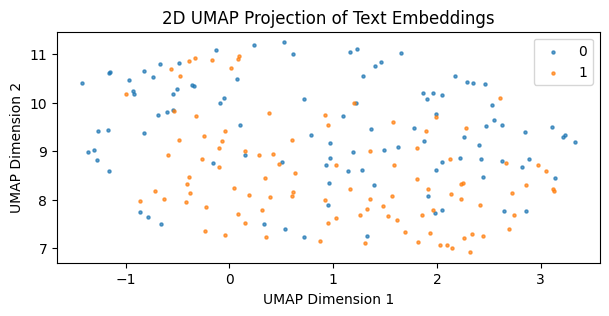

In [25]:
# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(7, 3))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, alpha=0.7, s=5)
plt.legend()
plt.title('2D UMAP Projection of Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

There is no clear separating between examples of the different label classes.

### The effect of this disorder on classifications

Let's see how a classifier using these embeddings would classify a single sentence:

In [26]:
text = examples.text.values[0]
true_label = examples.label.values[0]
print("Text:", repr(text))
print("True Label:", repr(true_label))

Text: 'National security is dependent on a sound defence policy, a sound foreign policy and wise leadership .'
True Label: np.int64(0)


Inputting the tokenized version fo the text to the model with the **classification head** outputs logits:


In [27]:
# get the logits for the first text
text = examples.text.values[0]
inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

There are many values as label classes in `logits`:

In [28]:
logits.shape

(2,)

Because interpreting logits is hard, let's the logits toprobabilities using the softmax function:

In [29]:
import torch.nn.functional as F

# Apply softmax to logits and sort by probability
probs = F.softmax(torch.tensor(logits), dim=0).numpy()
# map probs to label class names
probs_dict = dict(zip(label2id.keys(), probs))
# sort by probability
probs_dict = dict(sorted(probs_dict.items(), key=lambda item: item[1]))

In [30]:
# Apply softmax to logits
probs = F.softmax(torch.tensor(logits), dim=0).numpy()
# sort the softmax logits and corresponding labels
sorted_indices = np.argsort(probs)
probs = probs[sorted_indices]

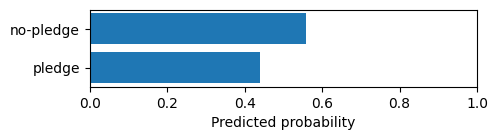

In [ ]:
# Plot the softmax logits as a bar plot
plt.figure(figsize=(5, 1))
plt.barh(list(probs_dict.keys()), list(probs_dict.values()))
plt.xlabel('Predicted probability')
plt.xlim(0, 1)
plt.ylabel('')
plt.show()

We can see the classifier seems **really undecided** about what topic it should predict for the sentence!

Well, this is understandable.
As we have seen above, the model cannot really separate between texts from different label categories.

This is because it has _not_ been finetuned for this classification task.

So let's look how this looks for a classifier that _has_ been finetuned for this task ☺️

## after fine-tuning

Now, let's see what happens if we do the same for the **model that has been _finetuned_** on task-specific labeled data:

In [33]:
# load the source model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_NAME).to(device)

#### nice clustering of output embeddings by label class after finetuning ✅ 

Below you set, in contrast to the source model, the finetuned model produces contextualized embeddings that are nicely clustering by label class of the inputted texts:

In [34]:
# get the transformer embeddings
finetuned_embeddings = get_last_hidden_state(examples.text.tolist(), tokenizer, model)

  0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
# Apply UMAP to reduce embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
finetuned_embeddings_2d = reducer.fit_transform(finetuned_embeddings)

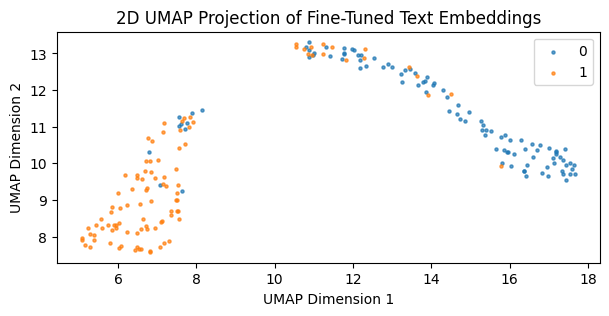

In [38]:
# Plot texts' embeddings in 2D coloring points by values in column label
plt.figure(figsize=(7, 3))
for label in examples['label'].unique():
    indices = examples['label'] == label
    plt.scatter(finetuned_embeddings_2d[indices, 0], finetuned_embeddings_2d[indices, 1], label=label, alpha=0.7, s=5)
plt.legend()
plt.title('2D UMAP Projection of Fine-Tuned Text Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

#### High-certainty predicted label class probabilties ✅

Let's look at the logits predicted by this model

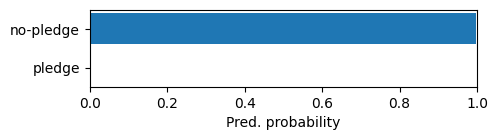

In [41]:
# get the logits for the first text
# NOTE: we are reusing `text` defined above (`text = examples.text.values[0]`)

inputs = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs.to(model.device))
logits = outputs.logits.cpu().detach().numpy()[0]

# Apply softmax to logits and sort by probability
probs_finetuned = F.softmax(torch.tensor(logits), dim=0).numpy()
probs_finetuned_dict = dict(zip(label2id.keys(), probs_finetuned))
probs_finetuned_dict = dict(sorted(probs_finetuned_dict.items(), key=lambda item: item[1]))

# Plot the softmax logits as a bar plot
plt.figure(figsize=(5, 1))
plt.barh(list(probs_finetuned_dict.keys()), list(probs_finetuned_dict.values()))
plt.xlabel('Pred. probability')
plt.xlim(0, 1)
plt.ylabel('')
plt.show()

Now this looks much better! The most likely label class aligns with the "true" label with very high probability

In [43]:
id2label[true_label]

'no-pledge'